Let's keep working through the example at the link, this time looking at another common use for radar data - Rain Rate.

https://github.com/CSU-Radarmet/CSU_RadarTools/blob/master/notebooks/CSU_RadarTools_Demo.ipynb

Again, we will set up some initial functions, so we will just run the next lines to save time, but I encourage you to come back and look at them later!

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pyart
import glob
from skewt import SkewT
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc, fundamentals)
%matplotlib inline

In [16]:
def radar_coords_to_cart(rng, az, ele, debug=False):
    """
    TJL - taken from old Py-ART version
    Calculate Cartesian coordinate from radar coordinates
    Parameters
    ----------
    rng : array
        Distances to the center of the radar gates (bins) in kilometers.
    az : array
        Azimuth angle of the radar in degrees.
    ele : array
        Elevation angle of the radar in degrees.
    Returns
    -------
    x, y, z : array
        Cartesian coordinates in meters from the radar.
    Notes
    -----
    The calculation for Cartesian coordinate is adapted from equations
    2.28(b) and 2.28(c) of Doviak and Zrnic [1]_ assuming a
    standard atmosphere (4/3 Earth's radius model).
    .. math::
        z = \\sqrt{r^2+R^2+r*R*sin(\\theta_e)} - R
        s = R * arcsin(\\frac{r*cos(\\theta_e)}{R+z})
        x = s * sin(\\theta_a)
        y = s * cos(\\theta_a)
    Where r is the distance from the radar to the center of the gate,
    :math:\\theta_a is the azimuth angle, :math:\\theta_e is the
    elevation angle, s is the arc length, and R is the effective radius
    of the earth, taken to be 4/3 the mean radius of earth (6371 km).
    References
    ----------
    .. [1] Doviak and Zrnic, Doppler Radar and Weather Observations, Second
        Edition, 1993, p. 21.
    """
    theta_e = ele * np.pi / 180.0  # elevation angle in radians.
    theta_a = az * np.pi / 180.0  # azimuth angle in radians.
    R = 6371.0 * 1000.0 * 4.0 / 3.0  # effective radius of earth in meters.
    r = rng * 1000.0  # distances to gates in meters.

    z = (r ** 2 + R ** 2 + 2.0 * r * R * np.sin(theta_e)) ** 0.5 - R
    s = R * np.arcsin(r * np.cos(theta_e) / (R + z))  # arc length in m.
    x = s * np.sin(theta_a)
    y = s * np.cos(theta_a)
    return x, y, z


def get_z_from_radar(radar):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/1000.0, az_2d, el_2d)
    return zz + radar.altitude['data']


def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = sounding.soundingdata['temp']  # In old SkewT, was sounding.data
    snd_z = sounding.soundingdata['hght']  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    if not snd_T.mask[0]: #May cause issue for specific soundings
        dummy_z.append(snd_z[0])
        dummy_T.append(snd_T[0])
        for i, height in enumerate(snd_z):
            if i > 0:
                if snd_z[i] > snd_z[i-1] and not snd_T.mask[i]:
                    dummy_z.append(snd_z[i])
                    dummy_T.append(snd_T[i])
        snd_z = np.array(dummy_z)
        snd_T = np.array(dummy_T)
    return snd_T, snd_z


def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()
    rad_T1d = np.interp(rad_z1d, snd_z, snd_T)
    return np.reshape(rad_T1d, shape), radar_z

In [17]:
def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='reflectivity'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

In [18]:
def two_panel_plot_ppi(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65,
                   cmap1='RdYlBu_r', units1='dBZ', var2='differential_reflectivity',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-100,100], ylim=[-100,100]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13,5))
    ax1 = fig.add_subplot(121)
    display.plot_ppi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_ppi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display

In [19]:
def two_panel_plot_rhi(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65,
                   cmap1='RdYlBu_r', units1='dBZ', var2='differential_reflectivity',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-100,100], ylim=[-100,100]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13,5))
    ax1 = fig.add_subplot(121)
    display.plot_rhi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_rhi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display

In [20]:
hid_colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
              'Cyan', 'DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphid = colors.ListedColormap(hid_colors)
cmapmeth = colors.ListedColormap(hid_colors[0:6])
cmapmeth_trop = colors.ListedColormap(hid_colors[0:7])

def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 10, 0.9))
    cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                           'Wet Snow', 'Vertical Ice', 'LD Graupel',
                           'HD Graupel', 'Hail', 'Big Drops'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

def adjust_meth_colorbar_for_pyart(cb, tropical=False):
    if not tropical:
        cb.set_ticks(np.arange(1.25, 5, 0.833))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z)', 'R(Zrain)'])
    else:
        cb.set_ticks(np.arange(1.3, 6, 0.85))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z_all)', 'R(Z_c)', 'R(Z_s)'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

# RainRate

First, let's grab a file and run the HID on it, since it uses this to help determine rain from ice. I will run through this quickly, since we have already done this in the previous notebook. 

For simplicity, I will do this using the CSAPR data, but remember to calculate KDP if your radar doesn't include it!

In [21]:
sndfile = 'LCH_sounding.txt'
radarfile = 'houcsapr2cfrqcS2.b1/houcsapr2cfrqcS2.b1.20220701.192603.nc'
radar = pyart.io.read(radarfile)
print(radar.fields.keys())
sounding = SkewT.Sounding(sndfile)

dict_keys(['attenuation_corrected_differential_reflectivity', 'attenuation_corrected_differential_reflectivity_lag_1', 'attenuation_corrected_reflectivity_h', 'censor_mask', 'classification_mask', 'copol_correlation_coeff', 'differential_phase', 'differential_reflectivity', 'differential_reflectivity_lag_1', 'mean_doppler_velocity', 'mean_doppler_velocity_v', 'normalized_coherent_power', 'normalized_coherent_power_v', 'reflectivity', 'reflectivity_v', 'signal_to_noise_ratio_copolar_h', 'signal_to_noise_ratio_copolar_v', 'specific_attenuation', 'specific_differential_attenuation', 'specific_differential_phase', 'spectral_width', 'spectral_width_v', 'uncorrected_copol_correlation_coeff', 'uncorrected_differential_phase', 'uncorrected_differential_reflectivity', 'uncorrected_differential_reflectivity_lag_1', 'uncorrected_mean_doppler_velocity_h', 'uncorrected_mean_doppler_velocity_v', 'uncorrected_reflectivity_h', 'uncorrected_reflectivity_v', 'uncorrected_spectral_width_h', 'uncorrected_

In [22]:
dz = radar.fields['reflectivity']['data']
dr = radar.fields['differential_reflectivity']['data']
kd = radar.fields['specific_differential_phase']['data']
rh = radar.fields['copol_correlation_coeff']['data']

In [23]:
radar_T, radar_z = interpolate_sounding_to_radar(sounding, radar)

In [24]:
scores = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True, band='C',
                                T=radar_T)
fh = scores -1

In [25]:
radar = add_field_to_radar_object(fh, radar)

Now that the HID is added to the file, we can continue with  the rain rate calculations.

The CSU Radartools library has many options for calculating rain rate, from individual relations like Z-R or R(KDP), to more complicated ones. For the simple relationships, you can specify coefficients to ones you prefer, or use the defaults they chose from literature.

There are two complex ones:
1. calc_blended_rain - this funtion uses ZDP (difference reflectivity, Zh-Zv) to estimate ice fraction
2. calc_hidro_rain - uses HID to find ice regions

Outputs from both of the more complex methods contain both the rain rate and the method used at that particular gate.

## csu_hidro_rain

In [39]:
rain, method = csu_blended_rain.csu_hidro_rain(
    dz=dz, zdr=dr, kdp=kd, fhc=fh, band='C', thresh_dz=35, thresh_kdp=0.15,
    r_z_a=200.0, r_z_b=1.4, r_kdp_a=29.71, r_kdp_b=0.85)
radar = add_field_to_radar_object(rain, radar, field_name='rain_C', units='mm h-1',
                                  long_name='HIDRO Rainfall Rate', 
                                  standard_name='Rainfall Rate')
radar = add_field_to_radar_object(method, radar, field_name='method_C', units='',
                                  long_name='HIDRO Rainfall Method', 
                                  standard_name='Rainfall Method')

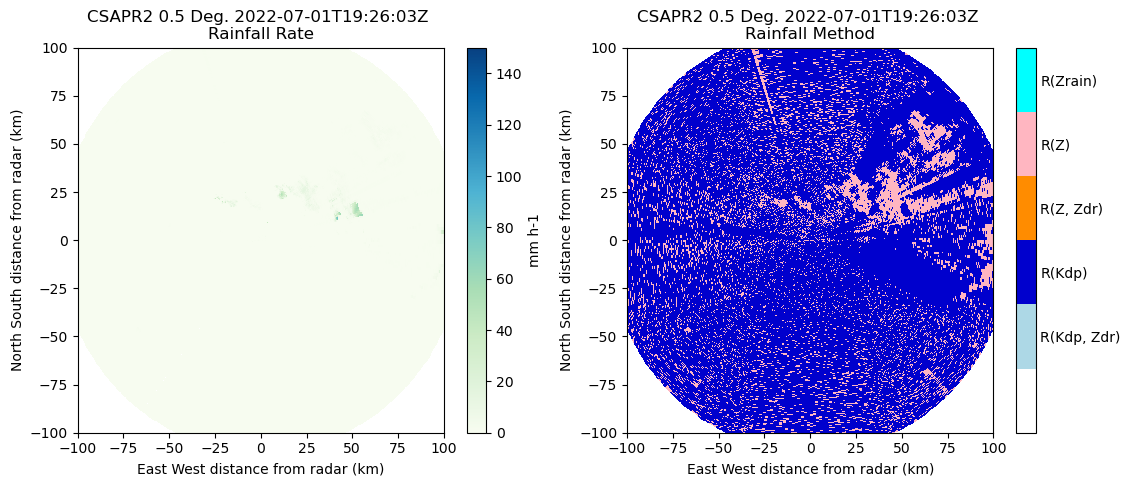

In [41]:
limx = [-100, 100]
limy = [-100,100]
fig, ax1, ax2, display = two_panel_plot_ppi(radar, sweep=0, var1='rain_C', vmin1=0, vmax1=150,
                                        cmap1='GnBu', var2='method_C', vmin2=0, vmax2=5, 
                                        cmap2=cmapmeth, units2='', return_flag=True, 
                                        xlim=limx, ylim=limy, units1='mm h-1')
display.cbs[1] = adjust_meth_colorbar_for_pyart(display.cbs[1])

As you can see, the most used method in the rain rate calculation for this were R(Z) in meteorological echos, and R(KDP) in non-meteorological regions.

## csu_blended_rain

In [42]:
rain, method, zdp, fi = csu_blended_rain.calc_blended_rain(dz=dz, zdr=dr, 
                                                           kdp=kd, ice_flag=True)
radar = add_field_to_radar_object(rain, radar, field_name='rain_blend', units='mm h-1',
                                  long_name='Blended Rainfall Rate', 
                                  standard_name='Rainfall Rate')
radar = add_field_to_radar_object(method, radar, field_name='method_blend', units='',
                                  long_name='Blended Rainfall Method', 
                                  standard_name='Rainfall Method')
radar = add_field_to_radar_object(zdp, radar, field_name='ZDP', units='dB',
                                  long_name='Difference Reflectivity',
                                  standard_name='Difference Reflectivity')
radar = add_field_to_radar_object(fi, radar, field_name='FI', units='', 
                                  long_name='Ice Fraction',
                                  standard_name='Ice Fraction')

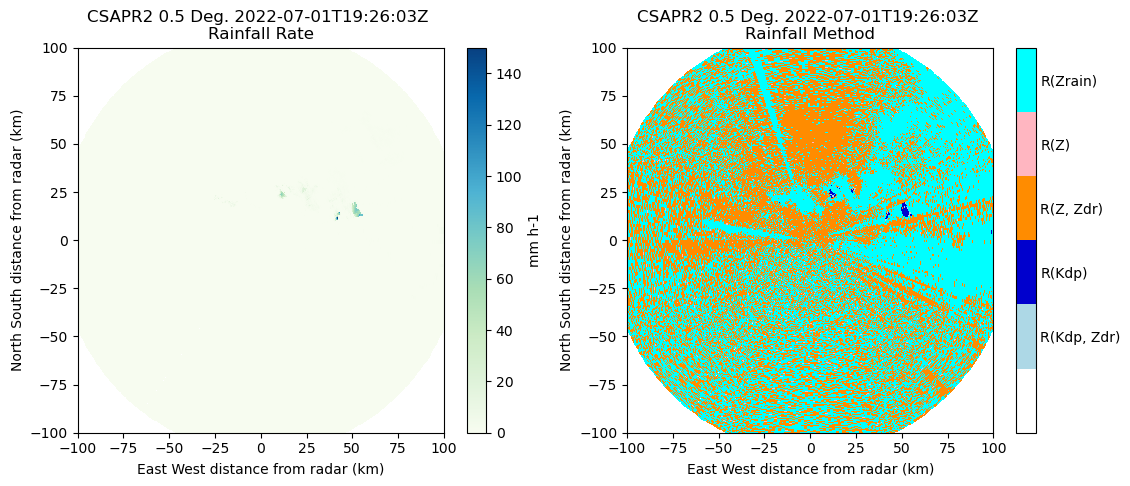

In [43]:
limx = [-100, 100]
limy = [-100,100]
fig, ax1, ax2, display = two_panel_plot_ppi(
    radar, sweep=0, var1='rain_blend', vmin1=0, vmax1=150, cmap1='GnBu',
    var2='method_blend', vmin2=0, vmax2=5, cmap2=cmapmeth, units2='',
    return_flag=True, xlim=limx, ylim=limy, units1='mm h-1')
display.cbs[1] = adjust_meth_colorbar_for_pyart(display.cbs[1])

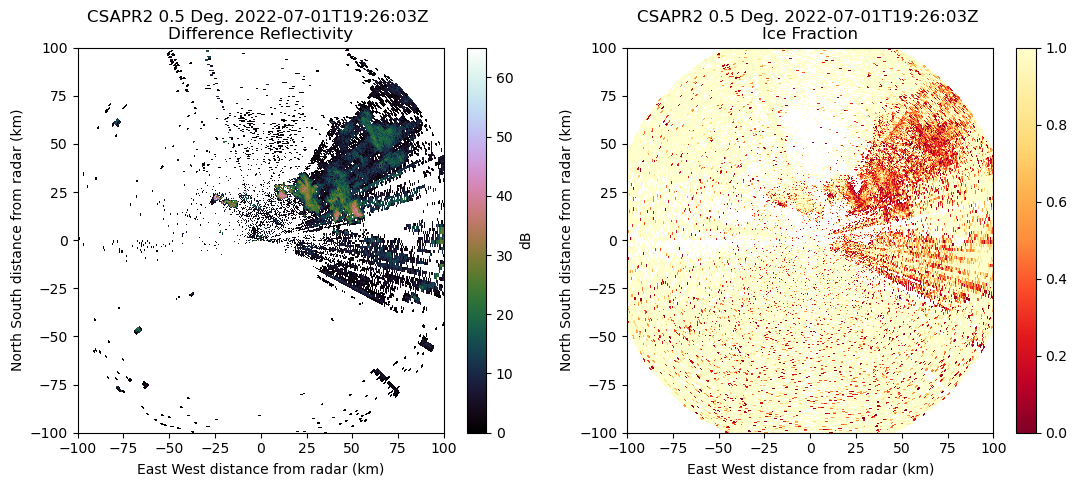

In [44]:
limx = [-100, 100]
limy = [-100,100]
two_panel_plot_ppi(radar, sweep=0, var1='ZDP', units1='dB', vmin1=0, vmax1=65,
               cmap1='cubehelix', var2='FI', vmin2=0, vmax2=1, 
               cmap2='YlOrRd_r', units2='', xlim=limx, ylim=limy)

Using this method, you can see that different methods were chosen to calculate the rain rate this time! 

In both algorithms, you can tell it which radar band you have - by default it assumes S band (like nexrads). 

Since C-band is often affected strongly by hail at ZDR, we need to make sure to tell it the radar band so it knows to not use methods that focus on that variable. Fortunately in our case, it appears this method wasn't used, but that won't always be the case. Telling it your radar band will also allow it to pick better coefficients for your radar!